### Notes and Sources

Presidential Votes by Precinct:
* https://voterportal.sos.la.gov/static/2012-11-06/resultsRegion/46257
* https://voterportal.sos.la.gov/static/2016-11-08/resultsRegion/53898

Watching the data on the network shows that json is retrievable through calls like this, for each county (1-64):
* https://voterportal.sos.la.gov/ElectionResults/ElectionResults/Data?blob=20161108/VotesRaceByPrecinct/Votes_53898_01.htm

Precinct-Level Shapefiles:
* http://house.louisiana.gov/H_Redistricting2011/default_LouisianaPrecinctShapefiles.htm


In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *


import pandas as pd
import geopandas as gpd
from IPython.display import display

import requests

import psycopg2
from netrc import netrc
from fiona.crs import from_epsg

user, acct, passwd = netrc().authenticators("harris")

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000

fips, epsg = 22, 3552
laf = "/media/jsaxon/brobdingnag/data/el_dv/la_site/"

In [2]:
! ls /media/jsaxon/brobdingnag/data/el_dv/la_site/

2012_LA_Precincts.dbf		       LA_2016.cpg	    la_geo_votes_16.shp
2012_LA_Precincts.prj		       LA_2016.dbf	    la_geo_votes_16.shx
2012_LA_Precincts.sbn		       LA_2016.prj	    la_geo_votes.cpg
2012_LA_Precincts.sbx		       LA_2016.shp	    la_geo_votes.dbf
2012_LA_Precincts.shp		       LA_2016.shx	    la_geo_votes.prj
2012_LA_Precincts.shp.xml	       la_geo_votes_12.cpg  la_geo_votes.shp
2012_LA_Precincts.shx		       la_geo_votes_12.dbf  la_geo_votes.shx
2012 Louisiana Precinct Shapefile.zip  la_geo_votes_12.prj  la.qgs
2016_LA_PRECINCTS.DBF		       la_geo_votes_12.shp  la_votes_2012.csv
2016_LA_Precincts.prj		       la_geo_votes_12.shx  la_votes_2016.csv
2016_LA_Precincts.shp		       la_geo_votes_16.cpg  sources.txt
2016_LA_Precincts.shx		       la_geo_votes_16.dbf
2016_LouisianaPrecinctShapefile.zip    la_geo_votes_16.prj


In [3]:
! cat /media/jsaxon/brobdingnag/data/el_dv/la_site/sources.txt

https://voterportal.sos.la.gov/static/#/
https://voterportal.sos.la.gov/static/#/2016-11-08/resultsRegion/53898/01

>> Get JSON here, by county (1-64)
https://voterportal.sos.la.gov/ElectionResults/ElectionResults/Data?blob=20161108/VotesRaceByPrecinct/Votes_53898_01.htm

http://house.louisiana.gov/H_Redistricting2011/default_LouisianaPrecinctShapefiles.htm


#### Last retrieved November 25, 2017

In [4]:
addr12 = "https://voterportal.sos.la.gov/ElectionResults/ElectionResults/Data?blob=20121106/VotesRaceByPrecinct/Votes_46257_{:02d}.htm"

df12 = []
for ci in []: # range(1, 65):

    js = requests.get(addr12.format(ci)).json()

    data = js["Precincts"]["Precinct"]
    for precinct in data:
        for choice in precinct["Choice"]:
            precinct[int(choice["ID"])] = int(choice["VoteTotal"])

    df = pd.DataFrame(data)
    df = df.rename(columns = {"Precinct" : "precinct", 90532 : "R12", 90536 : "D12"})
    df = df[["precinct", "D12", "R12"]]
    df["county"] = ci*2-1
    df12.append(df)
    
# df12 = pd.concat(df12)
# df12.replace({"precinct" : {"Early Voting" : "EV", "Provisional Votes" : "PR"}}, inplace = True)
# df12[["county", "precinct", "D12", "R12"]].to_csv(laf + "la_votes_2012.csv", index = False)

In [5]:
addr16 = "https://voterportal.sos.la.gov/ElectionResults/ElectionResults/Data?blob=20161108/VotesRaceByPrecinct/Votes_53898_{:02d}.htm"

df16 = []
for ci in []: # range(1, 65):

    js = requests.get(addr16.format(ci)).json()

    data = js["Precincts"]["Precinct"]
    for precinct in data:
        for choice in precinct["Choice"]:
            # print(choice)
            precinct[int(choice["ID"])] = int(choice["VoteTotal"])

    df = pd.DataFrame(data)
    df = df.rename(columns = {"Precinct" : "precinct", 101869 : "R16", 101870 : "D16"})
    df = df[["precinct", "D16", "R16"]]
    df["county"] = ci*2-1
    df16.append(df)
    
# df16 = pd.concat(df16)
# df16.replace({"precinct" : {"Early Voting" : "EV", "Provisional Votes" : "PR"}}, inplace = True)
# df16[["county", "precinct", "D16", "R16"]].to_csv(laf + "la_votes_2016.csv", index = False)

In [4]:
votes_12 = pd.read_csv(laf + "la_votes_2012.csv")
votes_16 = pd.read_csv(laf + "la_votes_2016.csv")

In [5]:
def allocate_prov_abs_votes(votes, yr):
    
    D, R = "D{}".format(yr%100), "R{}".format(yr%100)

    poll_mask = ~votes.precinct.str.contains("EV") & ~votes.precinct.str.contains("PR")
    
    poll_totals = votes[poll_mask].groupby("county").sum()[[D, R]].reset_index()\
                                  .rename(columns = {D : D + "_poll_tot", R : R + "_poll_tot"})\

    alt_totals = votes[~poll_mask].groupby("county").sum()[[D, R]].reset_index()\
                                  .rename(columns = {D : D + "_alt_tot", R : R + "_alt_tot"})\
                                          
    votes = pd.merge(votes, poll_totals, on = "county", how = "outer")
    votes = pd.merge(votes, alt_totals,  on = "county", how = "outer")
    votes.fillna(0, inplace = True)

    votes[D + "_poll_frac"], votes[R + "_poll_frac"] = 0, 0
    votes.loc[poll_mask, D + "_poll_frac"] = 1. * votes.loc[poll_mask, D] / votes.loc[poll_mask, D + "_poll_tot"]
    votes.loc[poll_mask, R + "_poll_frac"] = 1. * votes.loc[poll_mask, R] / votes.loc[poll_mask, R + "_poll_tot"]

    votes.loc[poll_mask, D] += votes.loc[poll_mask, D + "_alt_tot"] * votes.loc[poll_mask, D + "_poll_frac"]
    votes.loc[poll_mask, R] += votes.loc[poll_mask, R + "_alt_tot"] * votes.loc[poll_mask, R + "_poll_frac"]
        
    votes = votes.loc[poll_mask, ["county", "precinct", D, R]]
            
    return votes


### Gruesome merging for 2012

In [6]:
votes_12 = pd.read_csv(laf + "la_votes_2012.csv")

votes_12.loc[votes_12.county.isin([5, 7, 17, 33, 55, 57, 87, 89, 97, 109]), "precinct"] = votes_12.loc[votes_12.county.isin([5, 7, 17, 33, 55, 57, 87, 89, 97, 109]), "precinct"].str.replace(r" [ABCYZJKLM]", "")
votes_12.loc[votes_12.county.isin([15]), "precinct"] = votes_12.loc[votes_12.county.isin([15]), "precinct"].str.replace(r" -*[1-2]$", r"")
votes_12.loc[votes_12.county.isin([25, 43, 75, 89, 91, 99, 127]), "precinct"] = votes_12.loc[votes_12.county.isin([25, 43, 75, 89, 91, 99, 127]), "precinct"].str.replace(r"/", r"/0")
votes_12.loc[votes_12.county.isin([29]), "precinct"] = votes_12.loc[votes_12.county.isin([29]), "precinct"].str.replace(r"00/", r"0").str.replace(r"-", r"/0").str.replace(r"[24][AB]", "2")
votes_12.loc[votes_12.county.isin([67]), "precinct"] = votes_12.loc[votes_12.county.isin([67]), "precinct"].str.replace(r"00/([0-9]{2})-([12])", r"\1/0\2")
votes_12.loc[votes_12.county.isin([79]), "precinct"] = votes_12.loc[votes_12.county.isin([79]), "precinct"].str.replace(r" [AL][KZ]", "")

votes_12.loc[(votes_12.county == 3)   & (votes_12.precinct == "02/02A"), "precinct"] = "02/02-A"
votes_12.loc[(votes_12.county == 113) & (votes_12.precinct == "00/49B-2"), "precinct"] = "00/49B-1"
votes_12.loc[(votes_12.county == 121) & (votes_12.precinct == "00/02A"), "precinct"] = "00/02B"
votes_12.loc[(votes_12.county == 121) & (votes_12.precinct == "00/11B"), "precinct"] = "00/11A"

# votes_12.loc[votes_12.county == 105, "precinct"] = votes_12.loc[votes_12.county == 105, "precinct"].str.replace(r"0(28|40|42|45|70|72)A", r"0\1")


votes_12 = allocate_prov_abs_votes(votes_12, 2012)
votes_12 = votes_12.groupby(by = ["county", "precinct"]).sum().reset_index()

In [7]:
geo_12 = gpd.read_file(laf + "2012_LA_Precincts.shp") # Had to re-save on the Mac to get field data.
geo_12["county"] = geo_12.COUNTY.astype(int)
geo_12 = geo_12[["county", "UNIT_NAME", "VTD", "VTDI10", "UNITNUM", "geometry"]].sort_values(by = "VTD")

In [8]:
geo_12["precinct"] = geo_12["VTD"].str.replace(r'^([0-9]{,3}[A-FNSW]{,1})$', r'0-\1')\
                                  .str.replace(r'^([0-9]*)-([0-9]*)', r'0\1/0\2')\
                                  .str.replace(r'0([0-9]{2})', r'\1')

geo_12.loc[geo_12.county.isin([17, 33, 51, 55, 105, 109]), "precinct"] = geo_12.loc[geo_12.county.isin([17, 33, 51, 55, 105, 109]), "precinct"].str.replace(r'(0[0-5])/([0-9]{2}[AB]*)$', r'\1/0\2')
geo_12.loc[geo_12.county.isin([23]), "precinct"] = geo_12.loc[geo_12.county.isin([23]), "precinct"].str.replace(r"[EW]", "")
geo_12.loc[geo_12.county.isin([23]), "precinct"] = geo_12.loc[geo_12.county.isin([23]), "precinct"].str.replace(r"12[NS]", "12")


geo_12.loc[geo_12.county == 39, "precinct"] = geo_12.loc[geo_12.county == 39, "UNIT_NAME"].str.replace(r"Precinct ([0-9]{2})-([0-9]{4})", r"\1/\2")
geo_12.loc[geo_12.UNIT_NAME == "Precinct 2010A", "precinct"] = "02/2010A"
geo_12.loc[geo_12.UNIT_NAME == "Precinct 5010A", "precinct"] = "05/5010A"

geo_12.loc[geo_12.precinct.str.contains(r"1{,1}[89][AB]I"), "precinct"] = ("00/0" + geo_12.loc[geo_12.precinct.str.contains(r"1{,1}[89][AB]I"), "precinct"]).str.replace(r"/0([0-9]{2}[AB])", r"/\1")
geo_12.loc[(geo_12.county == 51) & geo_12.VTD.str.contains(r'[GHKLW]'), "precinct"] = geo_12.loc[(geo_12.county == 51) & geo_12.VTD.str.contains(r'[GHKLW]'), "VTD"].str.replace(r"^([0-9])", r"00\1").str.replace(r"^0*([0-9]{3})-([GIHKLW]{,2})", r"00/\2\1")
geo_12.loc[geo_12.county == 79, "precinct"] = geo_12.loc[geo_12.county == 79, "VTD"].str.replace(r"^([CNS])", r"00/\g<1>00").str.replace(r"^(00/[CNS])0*([0-9]{2})", r"\1\2")
geo_12.loc[geo_12.county == 85, "precinct"] = "00/" + geo_12.loc[geo_12.county == 85, "VTD"]

geo_12.loc[(geo_12.county == 3)   & geo_12.precinct.str.contains("05/01-A"), "precinct"] = "05/01A"
geo_12.loc[(geo_12.county == 15)  & geo_12.precinct.str.contains("02/05B"), "precinct"] = "02/05"
geo_12.loc[(geo_12.county == 103) & geo_12.precinct.str.contains(r'[ACFMPS]'), "precinct"] = "00/" + geo_12.loc[(geo_12.county == 103) & geo_12.precinct.str.contains(r'[ACFMPS]'), "precinct"]
geo_12.loc[(geo_12.county == 113) & geo_12.precinct.str.contains(r'-'), "precinct"] = ("00/" + geo_12.loc[(geo_12.county == 113) & geo_12.precinct.str.contains(r'-'), "precinct"]).str.replace("00/7A-1", "00/07A-1")
geo_12.loc[(geo_12.county == 113) & geo_12.precinct.str.contains("00/5A-1"), "precinct"] = "00/05A-1"
geo_12.loc[(geo_12.county == 119) & geo_12.precinct.str.contains(r'33I'), "precinct"] = "00/" + geo_12.loc[(geo_12.county == 119) & geo_12.precinct.str.contains(r'33I'), "precinct"]

geo_12.sort_values(by = ["county", "precinct"], inplace = True)

In [9]:
geo_votes_12 = geo_12.merge(votes_12, on = ["county", "precinct"], how = "right")[["county", "precinct", "D12", "R12", "geometry"]]
display(geo_votes_12.loc[(geo_votes_12.D12.isnull() | geo_votes_12.geometry.isnull()) & ~geo_votes_12.precinct.str.contains("Z")])
geo_votes_12.to_file(laf + "la_geo_votes_12.shp")

,county,precinct,D12,R12,geometry


### Gruesome merging for 2016

In [10]:
votes_16 = pd.read_csv(laf + "la_votes_2016.csv")

votes_16.loc[votes_16.county.isin([5, 7, 17, 33, 55, 57, 89, 97, 109]), "precinct"] = votes_16.loc[votes_16.county.isin([5, 7, 17, 33, 55, 57, 89, 97, 109]), "precinct"].str.replace(r" [ABCYZJKLM]", "")
votes_16.loc[votes_16.county.isin([15]), "precinct"] = votes_16.loc[votes_16.county.isin([15]), "precinct"].str.replace(r" -[1-2]$", r"")
votes_16.loc[votes_16.county.isin([25, 43, 75, 89, 91, 127]), "precinct"] = votes_16.loc[votes_16.county.isin([25, 43, 75, 89, 91, 127]), "precinct"].str.replace(r"/", r"/0")
votes_16.loc[votes_16.county.isin([29]), "precinct"] = votes_16.loc[votes_16.county.isin([29]), "precinct"].str.replace(r"00/", r"0").str.replace(r"-", r"/0")
votes_16.loc[votes_16.county.isin([67]), "precinct"] = votes_16.loc[votes_16.county.isin([67]), "precinct"].str.replace(r"00/([0-9]{2})-([12])", r"\1/0\2")
votes_16.loc[votes_16.county.isin([79]), "precinct"] = votes_16.loc[votes_16.county.isin([79]), "precinct"].str.replace(r" [AL][KZ]", "")

votes_16.loc[(votes_16.county == 3)   & (votes_16.precinct == "02/02A"), "precinct"] = "02/02-A"
votes_16.loc[(votes_16.county == 113) & (votes_16.precinct == "00/49B-2"), "precinct"] = "00/49B-1"
votes_16.loc[(votes_16.county == 121) & (votes_16.precinct == "00/02A"), "precinct"] = "00/02B"
votes_16.loc[(votes_16.county == 121) & (votes_16.precinct == "00/11B"), "precinct"] = "00/11A"

# votes_16.loc[votes_16.county == 105, "precinct"] = votes_16.loc[votes_16.county == 105, "precinct"].str.replace(r"0(28|40|42|45|70|72)A", r"0\1")


votes_16 = allocate_prov_abs_votes(votes_16, 2016)
votes_16 = votes_16.groupby(by = ["county", "precinct"]).sum().reset_index()

In [11]:
geo_16 = gpd.read_file(laf + "LA_2016.shp") # Had to re-save on the Mac to get field data.
geo_16["county"] = geo_16.COUNTY.astype(int)
geo_16 = geo_16[["county", "ID", "UNIT_NAME", "VTD", "VTDI10", "UNITNUM", "geometry"]].sort_values(by = "VTD")
geo_16["precinct"] = ""

In [12]:
geo_16["precinct"] = geo_16["VTD"].str.replace(r'^([0-9]{,3}[A-FNSW]{,1})$', r'0-\1')\
                                  .str.replace(r'^([0-9]*)-([0-9]*)', r'0\1/0\2')\
                                  .str.replace(r'0([0-9]{2})', r'\1')

geo_16.loc[geo_16.county.isin([17, 33, 51, 55, 105, 109]), "precinct"] = geo_16.loc[geo_16.county.isin([17, 33, 51, 55, 105, 109]), "precinct"].str.replace(r'(0[0-5])/([0-9]{2}[A]*)$', r'\1/0\2')

geo_16.loc[geo_16.county == 39, "precinct"] = geo_16.loc[geo_16.county == 39, "UNIT_NAME"].str.replace(r"Precinct ([0-9]{2})-([0-9]{4})", r"\1/\2")
geo_16.loc[geo_16.UNIT_NAME == "Precinct 2010A", "precinct"] = "02/2010A"

geo_16.loc[(geo_16.county == 49) & (geo_16.precinct == "19AI"), "precinct"] = "00/19AI"
geo_16.loc[(geo_16.county == 51) & geo_16.VTD.str.contains(r'[GHKLW]'), "precinct"] = geo_16.loc[(geo_16.county == 51) & geo_16.VTD.str.contains(r'[GHKLW]'), "VTD"].str.replace(r"^([0-9])", r"00\1").str.replace(r"^0*([0-9]{3})-([GIHKLW]{,2})", r"00/\2\1")
geo_16.loc[geo_16.county == 79, "precinct"] = geo_16.loc[geo_16.county == 79, "VTD"].str.replace(r"^([CNS])", r"00/\g<1>00").str.replace(r"^(00/[CNS])0*([0-9]{2})", r"\1\2")
geo_16.loc[geo_16.county == 85, "precinct"] = "00/" + geo_16.loc[geo_16.county == 85, "VTD"]
geo_16.loc[(geo_16.county == 87) & (geo_16.precinct == "00/58"), "precinct"] = "00/51" # This the sole non-match.
geo_16.loc[(geo_16.county == 103) & geo_16.precinct.str.contains(r'[ACFMPS]'), "precinct"] = "00/" + geo_16.loc[(geo_16.county == 103) & geo_16.precinct.str.contains(r'[ACFMPS]'), "precinct"]
geo_16.loc[(geo_16.county == 113) & geo_16.precinct.str.contains(r'-'), "precinct"] = ("00/" + geo_16.loc[(geo_16.county == 113) & geo_16.precinct.str.contains(r'-'), "precinct"]).str.replace("00/7A-1", "00/07A-1")

geo_16.sort_values(by = ["county", "precinct"], inplace = True)

In [13]:
geo_votes_16 = geo_16.merge(votes_16, on = ["county", "precinct"], how = "outer")[["county", "precinct", "D16", "R16", "geometry"]]
geo_votes_16.to_file(laf + "la_geo_votes_16.shp")

### For sanity, output these as pannable maps...

In [14]:
geo_votes_12["DFrac"] = geo_votes_12.D12 / (geo_votes_12.D12 + geo_votes_12.R12)
geo_votes_16["DFrac"] = geo_votes_16.D16 / (geo_votes_16.D16 + geo_votes_16.R16)

output_geojson(geo_votes_12, var = "DFrac", fname = "mapped/la_2012.geojson")
output_geojson(geo_votes_16, var = "DFrac", fname = "mapped/la_2016.geojson")

### Now merge them to census tracts.

In [2]:
geo_votes_2012 = gpd.read_file(laf + "la_geo_votes_12.shp").to_crs(epsg = epsg)
geo_votes_2016 = gpd.read_file(laf + "la_geo_votes_16.shp").to_crs(epsg = epsg)

In [3]:
tr_rn = get_tr_rn("la").to_crs(epsg = epsg)

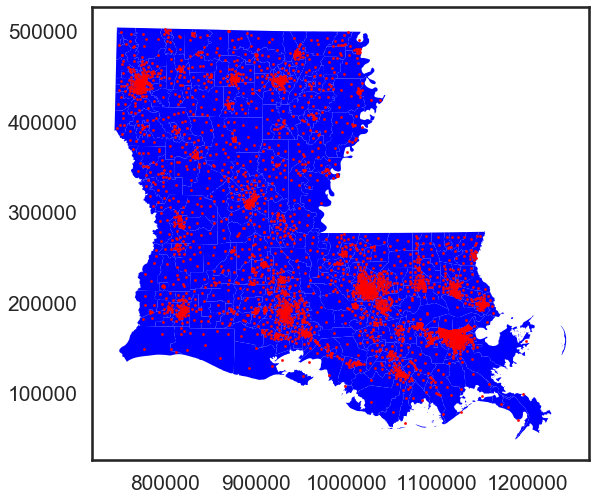

In [4]:
ax = tr_rn.plot(color = "blue")
geo_votes_2016.centroid.plot(color = "red", ax = ax, markersize = 1)

In [5]:
tr_votes_2012 = merge_tract_number(tr_rn, geo_votes_2012)[["D12", "R12"]]
tr_votes_2016 = merge_tract_number(tr_rn, geo_votes_2016)[["D16", "R16"]]

la_votes = tr_votes_2012.join(tr_votes_2016).fillna(0).astype(float)

la_votes.to_csv("votes/la.csv")

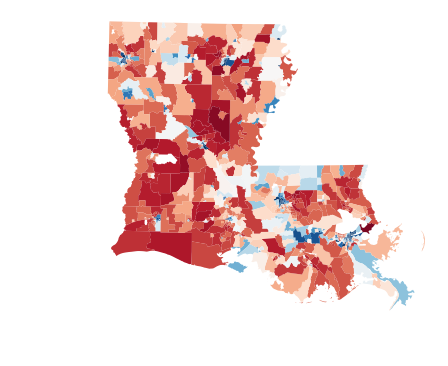

In [6]:
map_sanity_check("la", 2012, epsg)